Sector Tickers Loaded:
Information Technology: 69 tickers


Testing Cointegration: 100%|██████████| 591/591 [01:12<00:00,  8.19it/s]


Top Cointegrated Pairs:
             Pair   P-Value
47   (CDNS, SNPS)  0.000005
37   (AAPL, MPWR)  0.000026
39   (AMAT, NXPI)  0.000039
2     (ACN, INTU)  0.000085
100    (TER, TYL)  0.000099
9     (ADBE, CRM)  0.000245
17     (AMD, NOW)  0.000246
24     (ADI, CDW)  0.000453
45   (CDNS, KLAC)  0.000892
92   (QRVO, SWKS)  0.000899


Optimizing Pairs: 100%|██████████| 102/102 [1:36:40<00:00, 56.87s/it] 


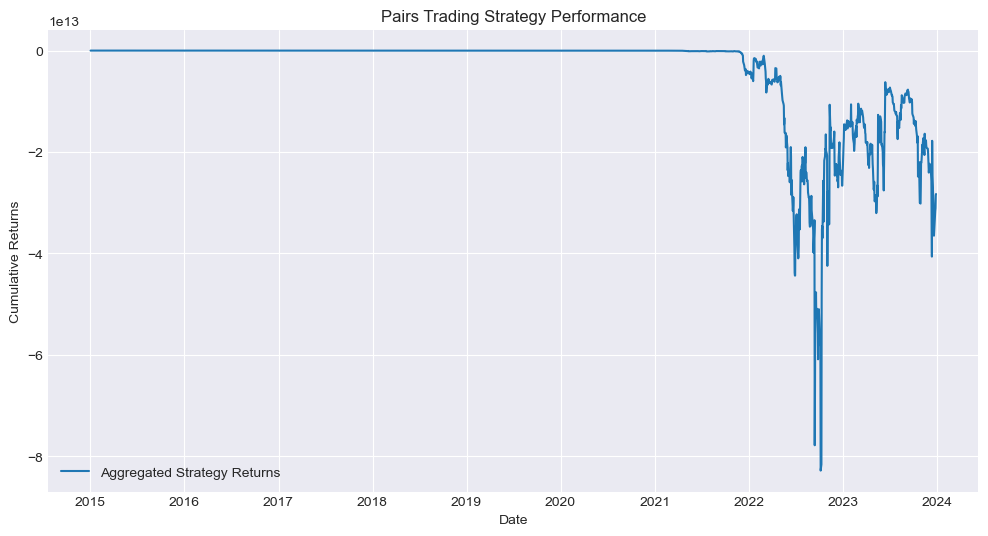

Top Results Across All Pairs:
            Pair  Entry Threshold  Exit Threshold  Rolling Window  \
27   (ADI, MSFT)              2.5             0.3              21   
1     (ACN, CDW)              2.0             0.3              35   
42   (ADSK, CRM)              3.0             0.3              42   
46  (CDNS, ORCL)              1.5             0.3              35   
24    (ADI, CDW)              2.0             0.3              14   
..           ...              ...             ...             ...   
94   (QCOM, TER)              2.0             0.3              14   
21   (APH, MPWR)              1.5             0.3              21   
69  (LRCX, MPWR)              1.5             0.3              14   
93   (QCOM, NOW)              2.5             0.3              14   
62   (JBL, NVDA)              2.0             0.3              14   

    Sharpe Ratio  
27      1.029570  
1       0.973167  
42      0.964823  
46      0.957420  
24      0.947818  
..           ...  
94      

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.regression.rolling import RollingOLS
from itertools import product
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

def get_sector_tickers(sectors_to_include=None, sectors_to_exclude=None):
    sp500_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
    sp500_df['Symbol'] = sp500_df['Symbol'].str.replace('.', '-')
    sp500_sectors = sp500_df[['Symbol', 'GICS Sector']]

    if sectors_to_include:
        sp500_sectors = sp500_sectors[sp500_sectors['GICS Sector'].isin(sectors_to_include)]
    if sectors_to_exclude:
        sp500_sectors = sp500_sectors[~sp500_sectors['GICS Sector'].isin(sectors_to_exclude)]

    return sp500_sectors.groupby('GICS Sector')['Symbol'].apply(list).to_dict()

included_sectors = ["Information Technology"] 
sector_tickers = get_sector_tickers(sectors_to_include=included_sectors)

print("Sector Tickers Loaded:")
for sector, tickers in sector_tickers.items():
    print(f"{sector}: {len(tickers)} tickers")

START = "2015-01-01"
END = "2023-12-31"

data = pd.DataFrame()
for sector, tickers in sector_tickers.items():
    for ticker in tqdm(tickers, desc=f"Downloading {sector}"):
        try:
            df = yf.download(ticker, start=START, end=END, progress=False)
            if not df.empty:
                data[ticker] = df['Adj Close']
        except Exception as e:
            print(f"Could not download {ticker}: {e}")

data.dropna(axis=1, inplace=True)

corr_matrix = data.corr().abs()

def get_highly_correlated_pairs(corr_matrix, threshold=0.9):
    correlated_pairs = []
    tickers = corr_matrix.columns
    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            if corr_matrix.iloc[i, j] >= threshold:
                correlated_pairs.append((tickers[i], tickers[j]))
    return correlated_pairs

high_corr_pairs = get_highly_correlated_pairs(corr_matrix, threshold=0.9)

def find_cointegrated_pairs(data, pairs, significance_level=0.05):
    coint_pairs = []
    pvalues = []
    for pair in tqdm(pairs, desc="Testing Cointegration"):
        s1 = data[pair[0]]
        s2 = data[pair[1]]
        result = ts.coint(s1, s2)
        pvalue = result[1]
        if pvalue < significance_level:
            coint_pairs.append(pair)
            pvalues.append(pvalue)
    return coint_pairs, pvalues

cointegrated_pairs, pvalues = find_cointegrated_pairs(data, high_corr_pairs)

coint_df = pd.DataFrame({
    'Pair': cointegrated_pairs,
    'P-Value': pvalues
}).sort_values('P-Value')

print("Top Cointegrated Pairs:")
print(coint_df.head(10))

if coint_df.empty:
    print("No cointegrated pairs found. Exiting...")
    exit()

entry_thresholds = np.arange(1.5, 3.1, 0.5)
exit_thresholds = np.arange(0.3, 1.1, 0.2)
rolling_windows = range(14, 43, 7)

all_strategy_returns = pd.DataFrame()

def evaluate_strategy(pair, entry, exit, window):
    S1, S2 = pair
    pair_data = data[[S1, S2]].dropna()
    Y = pair_data[S1]
    X = sm.add_constant(pair_data[S2])
    rolling_model = RollingOLS(Y, X, window=window)
    rolling_results = rolling_model.fit()
    hedge_ratios = rolling_results.params[S2]
    intercepts = rolling_results.params['const']
    spread = Y - (hedge_ratios * pair_data[S2] + intercepts)
    spread_mean = spread.rolling(window=window).mean()
    spread_std = spread.rolling(window=window).std()
    zscore = (spread - spread_mean) / spread_std

    long_entries = zscore < -entry
    long_exits = zscore > -exit
    short_entries = zscore > entry
    short_exits = zscore < exit

    positions_S1 = pd.Series(0, index=pair_data.index)
    positions_S2 = pd.Series(0, index=pair_data.index)

    for t in range(len(zscore)):
        if long_entries.iloc[t]:
            positions_S1.iloc[t] = 1
            positions_S2.iloc[t] = -hedge_ratios.iloc[t]
        elif short_entries.iloc[t]:
            positions_S1.iloc[t] = -1
            positions_S2.iloc[t] = hedge_ratios.iloc[t]
        elif long_exits.iloc[t] or short_exits.iloc[t]:
            positions_S1.iloc[t] = 0
            positions_S2.iloc[t] = 0
        else:
            if t > 0:
                positions_S1.iloc[t] = positions_S1.iloc[t - 1]
                positions_S2.iloc[t] = positions_S2.iloc[t - 1]

    returns_S1 = pair_data[S1].pct_change()
    returns_S2 = pair_data[S2].pct_change()
    strategy_returns = positions_S1.shift(1) * returns_S1 + positions_S2.shift(1) * returns_S2
    strategy_returns.fillna(0, inplace=True)

    sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)
    return strategy_returns, sharpe_ratio

best_results = []
for idx, pair in enumerate(tqdm(cointegrated_pairs, desc="Optimizing Pairs")):
    best_sharpe = -np.inf
    best_strategy = None
    best_params = None

    for entry, exit, window in product(entry_thresholds, exit_thresholds, rolling_windows):
        try:
            strategy_returns, sharpe = evaluate_strategy(pair, entry, exit, window)
            if sharpe > best_sharpe:
                best_sharpe = sharpe
                best_strategy = strategy_returns
                best_params = (entry, exit, window)
        except Exception as e:
            print(f"Error optimizing pair {pair} with params ({entry}, {exit}, {window}): {e}")
            continue

    if best_strategy is not None:
        all_strategy_returns[pair] = best_strategy
        best_results.append((pair, *best_params, best_sharpe))

cumulative_returns = (1 + all_strategy_returns.sum(axis=1)).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='Aggregated Strategy Returns')
plt.title('Pairs Trading Strategy Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Display best results
best_results_df = pd.DataFrame(best_results, columns=['Pair', 'Entry Threshold', 'Exit Threshold', 'Rolling Window', 'Sharpe Ratio'])
print("Top Results Across All Pairs:")
print(best_results_df.sort_values('Sharpe Ratio', ascending=False))


In [36]:
display(best_results_df.sort_values('Sharpe Ratio', ascending=False))

,Pair,Entry Threshold,Exit Threshold,Rolling Window,Sharpe Ratio
27,"(ADI, MSFT)",2.5,0.3,21,1.029570
1,"(ACN, CDW)",2.0,0.3,35,0.973167
42,"(ADSK, CRM)",3.0,0.3,42,0.964823
46,"(CDNS, ORCL)",1.5,0.3,35,0.957420
24,"(ADI, CDW)",2.0,0.3,14,0.947818
...,...,...,...,...,...
94,"(QCOM, TER)",2.0,0.3,14,0.090209
21,"(APH, MPWR)",1.5,0.3,21,0.061088
69,"(LRCX, MPWR)",1.5,0.3,14,-0.019395
93,"(QCOM, NOW)",2.5,0.3,14,-0.021580


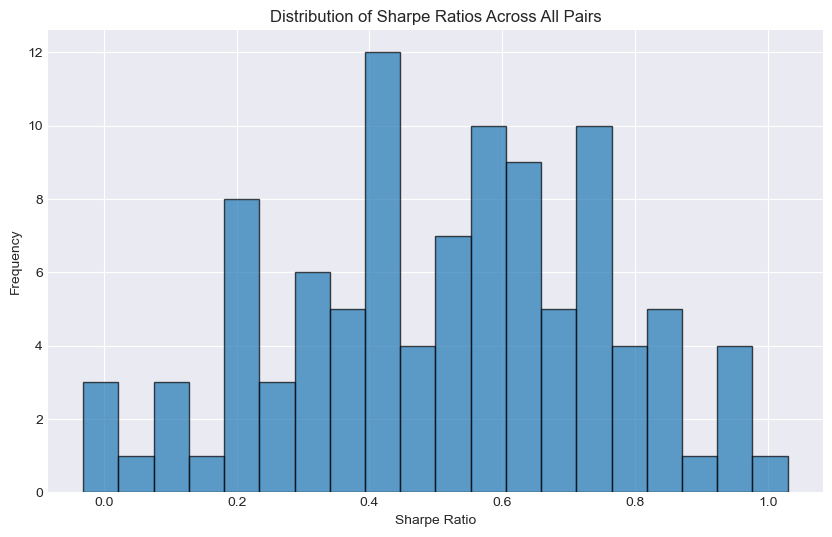

In [37]:
plt.figure(figsize=(10, 6))
plt.hist(best_results_df['Sharpe Ratio'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Sharpe Ratios Across All Pairs')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


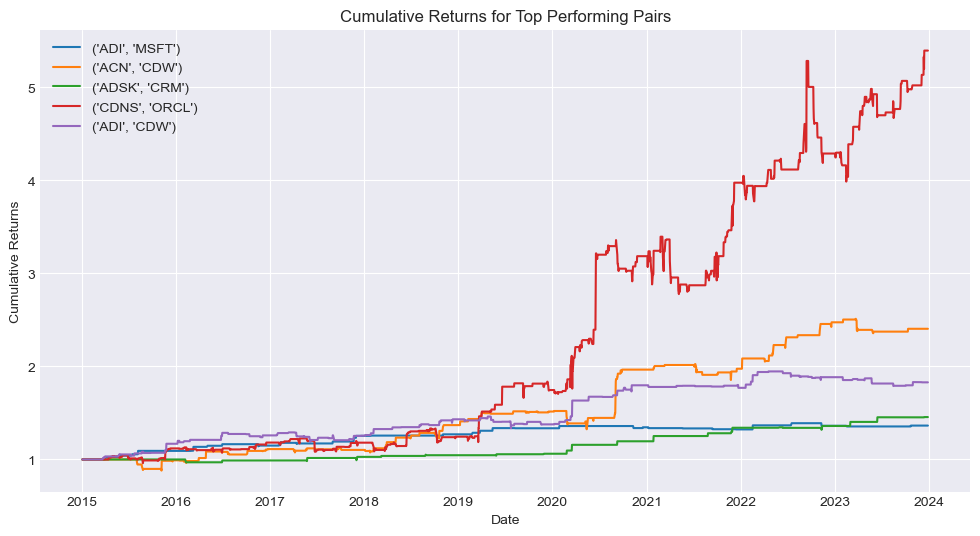

In [40]:
top_pairs = best_results_df.sort_values('Sharpe Ratio', ascending=False).head(5)['Pair']
plt.figure(figsize=(12, 6))

for pair in top_pairs:
    pair_cumulative_returns = (1 + all_strategy_returns[pair]).cumprod()
    plt.plot(pair_cumulative_returns, label=f"{pair}")

plt.title('Cumulative Returns for Top Performing Pairs')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


Z-Score Analysis

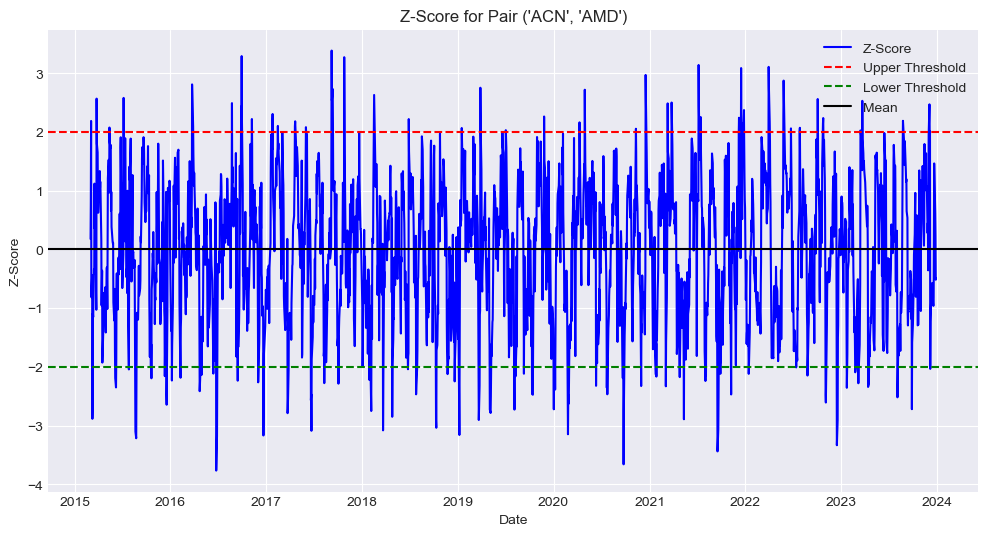

In [41]:
selected_pair = best_results_df.iloc[0]['Pair']
S1, S2 = selected_pair
pair_data = data[[S1, S2]].dropna()
Y = pair_data[S1]
X = sm.add_constant(pair_data[S2])
rolling_model = RollingOLS(Y, X, window=21)
rolling_results = rolling_model.fit()
hedge_ratios = rolling_results.params[S2]
intercepts = rolling_results.params['const']
spread = Y - (hedge_ratios * pair_data[S2] + intercepts)
spread_mean = spread.rolling(window=21).mean()
spread_std = spread.rolling(window=21).std()
zscore = (spread - spread_mean) / spread_std

plt.figure(figsize=(12, 6))
plt.plot(zscore, label='Z-Score', color='blue')
plt.axhline(2, color='red', linestyle='--', label='Upper Threshold')
plt.axhline(-2, color='green', linestyle='--', label='Lower Threshold')
plt.axhline(0, color='black', linestyle='-', label='Mean')
plt.title(f"Z-Score for Pair {selected_pair}")
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(True)
plt.show()


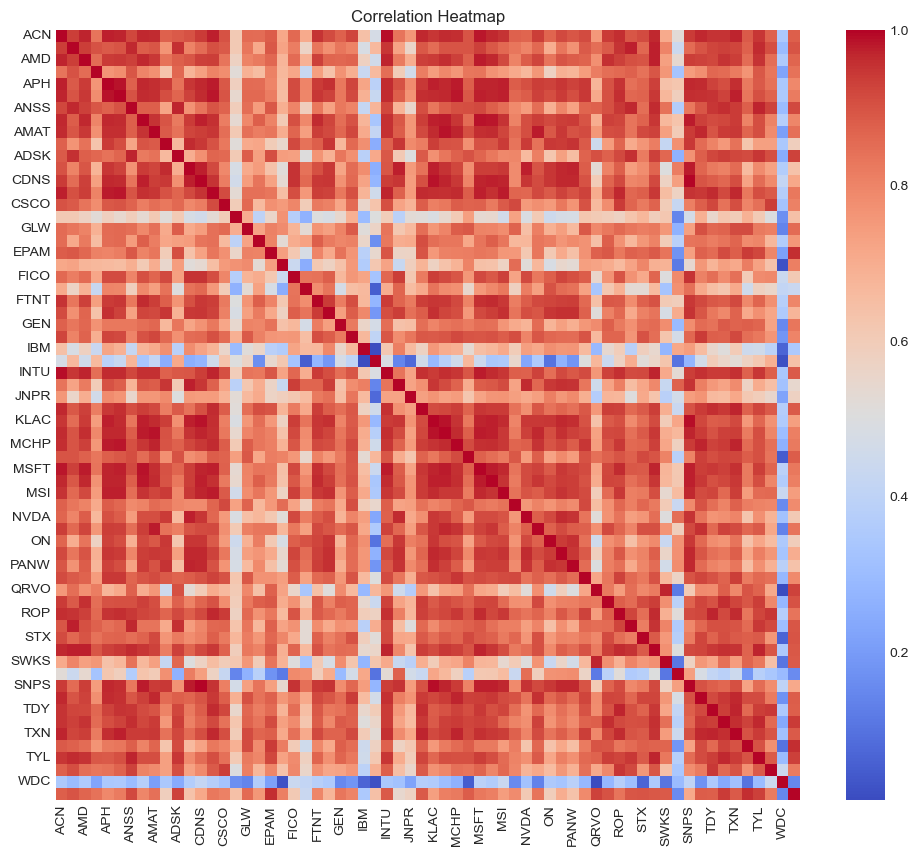

In [44]:
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()


## 1. Define Optimization Goals

The goal is to optimize a pairs trading strategy by maximizing the Sharpe Ratio. By optimizing this ratio, the strategy aims to achieve the best possible balance between profitability and stability.

For simplicity and computational efficiency, we are focusing our analysis on the IT sector of the S&P stocks.

## 2. Identify Parameters

- Entry Threshold: The z-score level that triggers a trade. When the z-score exceeds this threshold (either positively or negatively), the strategy initiates a position. This parameter determines how selective the strategy is when identifying trading opportunities.

- Exit Threshold: The z-score level at which the strategy exits a position. A lower exit threshold allows the strategy to close trades conservatively, limiting exposure to adverse price movements.

- Rolling Window Size: The number of days used to calculate the rolling hedge ratio and spread. This affects how sensitive the model is to recent price changes and the accuracy of the z-score calculation.

## 3. Set Parameter Ranges

We define the following range for optimization:

Entry Threshold: 1.5 to 3.0 with step size of 0.5. We start at 1.5 to avoid trading normal market noise.
Exit Threshold: 0.3 to 1.0 with a step size: 0.2
Rolling Window Size: 14 to 42 days with step size of 7 days

## 4. Choose an Optimization Method

Given the size of the parameter space, we will use a grid search optimization method to systematically test all possible combinations of parameters. 

## 5. Perform Optimization

Using the product function, we generate all combinations of entry_threshold, exit_threshold, and rolling_window.

For each parameter set, the strategy calculates the spread and z-score between the two stocks in a cointegrated pair and generates trading signals (long/short entry and exits) based on the thresholds. Then, it adjusts positions dynamically and calculates daily strategy returns.
The parameter combination with the highest Sharpe Ratio is stored for each cointegrated pair.